# Multiple Classification

Mount drive

In [ ]:
"""from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

#user_path = 'LUX/Mirabelle/'  #directory JP

base_dir = root_dir + user_path """

'from google.colab import drive                                                                        \ndrive.mount(\'/content/gdrive\', force_remount=True)\nroot_dir = "/content/gdrive/My Drive/"\n\n#user_path = \'LUX/Mirabelle/\'  #directory JP\n\nbase_dir = root_dir + user_path '

Importing libraries

In [ ]:
base_dir = './'

In [ ]:
#!pip install pycaret
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import seaborn as sns
import shap
import pickle


#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# settings to display all columns
pd.set_option("display.max_columns", None)

print('Libraries read!')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Libraries read!


# Loading processed data

In [ ]:
df = pd.read_csv(
    base_dir + 
    'df_processed_ml.csv')
print('Shape: ', df.shape)
df.head()

Shape:  (13894, 8)


teu_count  train_length  total_distance_trip  departure_delay  \
0      27.00         544.0           842.641085              4.0   
1      27.00         544.0           842.641085              5.0   
2      27.00         544.0           842.641085             30.0   
3       0.00          34.0           815.308053            258.0   
4      60.75         544.0           823.108788             33.0   

   arrival_delay  distance_between_control_stations  \
0           -3.0                          37.648801   
1         -137.0                         351.112938   
2            2.0                          96.509384   
3           66.0                         815.308053   
4           24.0                          37.648801   

   weight_per_length_of_train  weight_per_wagon_of_train  
0                    1.543105                  52.465562  
1                    1.543105                  52.465562  
2                    1.543105                  52.465562  
3                    1.029412                  35.000000  
4                    2.334463                  79.371750

In [ ]:
profile = ProfileReport(df, title='Pandas Profiling Report')
profile

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Engineering

In [ ]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13894 entries, 0 to 13893
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   teu_count                          13894 non-null  float64
 1   train_length                       13894 non-null  float64
 2   total_distance_trip                13894 non-null  float64
 3   departure_delay                    13894 non-null  float64
 4   arrival_delay                      13894 non-null  float64
 5   distance_between_control_stations  13894 non-null  float64
 6   weight_per_length_of_train         13894 non-null  float64
 7   weight_per_wagon_of_train          13894 non-null  float64
dtypes: float64(8)
memory usage: 868.5 KB


In [ ]:
df.describe(include='all')

teu_count  train_length  total_distance_trip  departure_delay  \
count  13894.000000  13894.000000         13894.000000     13894.000000   
mean      59.024552    536.541817           547.526374        84.585792   
std       20.954303    136.161078           274.099797       237.320179   
min        0.000000     14.000000            84.507306      -260.000000   
25%       48.295000    482.000000           310.118028       -12.000000   
50%       64.500000    544.000000           648.635532        20.000000   
75%       72.000000    646.000000           822.135405        87.000000   
max       98.360000    720.000000          1454.139924      1562.000000   

       arrival_delay  distance_between_control_stations  \
count   13894.000000                       13894.000000   
mean       78.403771                         126.583518   
std       245.377804                         172.749059   
min      -289.000000                           1.456555   
25%       -21.000000                          27.872309   
50%        12.000000                          74.186862   
75%        81.750000                         151.301458   
max      1570.000000                         815.308053   

       weight_per_length_of_train  weight_per_wagon_of_train  
count                13894.000000               13894.000000  
mean                     2.203449                  67.147480  
std                      0.525775                  16.478913  
min                      0.907077                  19.080000  
25%                      1.893750                  54.996333  
50%                      2.171699                  69.459000  
75%                      2.520779                  80.989524  
max                      4.083522                 119.340000

In [ ]:
df.columns

Index(['teu_count', 'train_length', 'total_distance_trip', 'departure_delay',
       'arrival_delay', 'distance_between_control_stations',
       'weight_per_length_of_train', 'weight_per_wagon_of_train'],
      dtype='object')

In [ ]:
df.isnull().sum()

teu_count                            0
train_length                         0
total_distance_trip                  0
departure_delay                      0
arrival_delay                        0
distance_between_control_stations    0
weight_per_length_of_train           0
weight_per_wagon_of_train            0
dtype: int64

In [ ]:
#Filling the null values with the median, because the null values in them are low...

df.fillna(df.median(), inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

teu_count                            0
train_length                         0
total_distance_trip                  0
departure_delay                      0
arrival_delay                        0
distance_between_control_stations    0
weight_per_length_of_train           0
weight_per_wagon_of_train            0
dtype: int64

In [ ]:
df.columns


Index(['teu_count', 'train_length', 'total_distance_trip', 'departure_delay',
       'arrival_delay', 'distance_between_control_stations',
       'weight_per_length_of_train', 'weight_per_wagon_of_train'],
      dtype='object')

## Creating new columns if the train arrives or departs early, on-time or late

In [ ]:
df[['arrival_delay']].head(10)

arrival_delay
0           -3.0
1         -137.0
2            2.0
3           66.0
4           24.0
5           21.0
6           39.0
7          -21.0
8           93.0
9          -19.0

In [ ]:
df_time = df[['arrival_delay']]
df_time = df_time[df_time['arrival_delay'] > 60].reset_index(drop=True)

print(f'Percentage of delayed trains (more than 1 hour): {round(df_time.shape[0]*100/df.shape[0], 1)}% ')
df_time.head(10)

Percentage of delayed trains (more than 1 hour): 30.1% 


arrival_delay
0           66.0
1           93.0
2          178.0
3          627.0
4          555.0
5          740.0
6           76.0
7          562.0
8          661.0
9          666.0

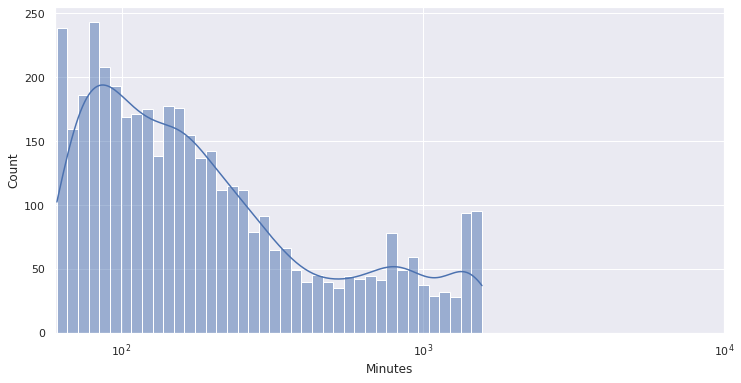

In [ ]:
sns.set(rc={'figure.figsize':(12,6)})
h = sns.histplot(data=df_time, x="arrival_delay", kde=True, bins=40, log_scale=True)
h.set(xlim=(60,10000))
plt.xlabel("Minutes") 

plt.savefig(base_dir + 'delayed_trains.png')

In [ ]:
def time_train(x):
    if x <= 60:
        return '0_on_time'
    if 60 < x and x <= 180:
        return '1_late'
    return '2_too_late'

In [ ]:
df['arrived'] = df['arrival_delay'].apply(lambda x: time_train(x))

In [ ]:
df['arrived'].value_counts(normalize=True)

0_on_time     0.698575
1_late        0.175831
2_too_late    0.125594
Name: arrived, dtype: float64

In [ ]:
# Removing the arrival_delay feature because I created the other one...
df.drop(columns=['arrival_delay'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13894 entries, 0 to 13893
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   teu_count                          13894 non-null  float64
 1   train_length                       13894 non-null  float64
 2   total_distance_trip                13894 non-null  float64
 3   departure_delay                    13894 non-null  float64
 4   distance_between_control_stations  13894 non-null  float64
 5   weight_per_length_of_train         13894 non-null  float64
 6   weight_per_wagon_of_train          13894 non-null  float64
 7   arrived                            13894 non-null  object 
dtypes: float64(7), object(1)
memory usage: 868.5+ KB


In order to demonstrate the predict_model() function on unseen data, a sample of 10% has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 10% records were not available at the time when the machine learning experiment was performed.

In [ ]:
df.columns

Index(['teu_count', 'train_length', 'total_distance_trip', 'departure_delay',
       'distance_between_control_stations', 'weight_per_length_of_train',
       'weight_per_wagon_of_train', 'arrived'],
      dtype='object')

In [ ]:
df.describe(include='all')

teu_count  train_length  total_distance_trip  departure_delay  \
count   13894.000000  13894.000000         13894.000000     13894.000000   
unique           NaN           NaN                  NaN              NaN   
top              NaN           NaN                  NaN              NaN   
freq             NaN           NaN                  NaN              NaN   
mean       59.024552    536.541817           547.526374        84.585792   
std        20.954303    136.161078           274.099797       237.320179   
min         0.000000     14.000000            84.507306      -260.000000   
25%        48.295000    482.000000           310.118028       -12.000000   
50%        64.500000    544.000000           648.635532        20.000000   
75%        72.000000    646.000000           822.135405        87.000000   
max        98.360000    720.000000          1454.139924      1562.000000   

        distance_between_control_stations  weight_per_length_of_train  \
count                        13894.000000                13894.000000   
unique                                NaN                         NaN   
top                                   NaN                         NaN   
freq                                  NaN                         NaN   
mean                           126.583518                    2.203449   
std                            172.749059                    0.525775   
min                              1.456555                    0.907077   
25%                             27.872309                    1.893750   
50%                             74.186862                    2.171699   
75%                            151.301458                    2.520779   
max                            815.308053                    4.083522   

        weight_per_wagon_of_train    arrived  
count                13894.000000      13894  
unique                        NaN          3  
top                           NaN  0_on_time  
freq                          NaN       9706  
mean                    67.147480        NaN  
std                     16.478913        NaN  
min                     19.080000        NaN  
25%                     54.996333        NaN  
50%                     69.459000        NaN  
75%                     80.989524        NaN  
max                    119.340000        NaN

data = merged_data.sample(frac=0.9, random_state=42)
data_unseen = merged_data.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))



# Modeling with Depart variance

In [ ]:
# Importing module and initialising setup
from pycaret.classification import *

classifier_merged_data = setup(data = df,
                               target = 'arrived',
                               session_id = 42,
                               normalize = True,
                               remove_outliers = True,
                               outliers_threshold = 0.15,
                               use_gpu = True,
                               fold_strategy = 'stratifiedkfold',
                               fix_imbalance = True,
                               data_split_stratify = True,
                               #log_experiment = True, 
                               #experiment_name = 'cfl1'
                               )

# Machine Learning models

In [ ]:
best_models = compare_models(sort='AUC', turbo=False) 

## gbc

In [ ]:
# Best ML analysis
gbc = create_model('gbc')

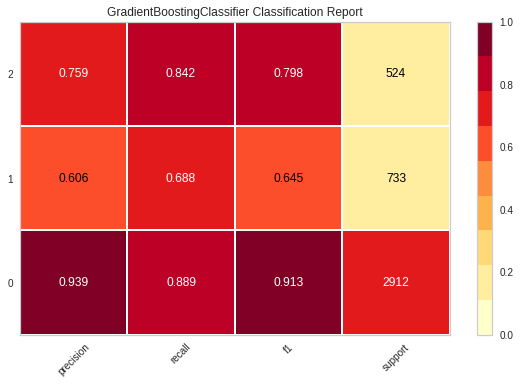

In [ ]:
# Plotting the classification report
plot_model(estimator = gbc, plot = 'class_report')

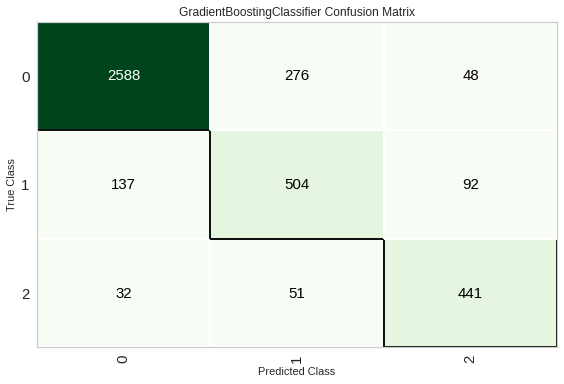

In [ ]:
# Plotting the confusion matrix
plot_model(estimator = gbc, plot = 'confusion_matrix')

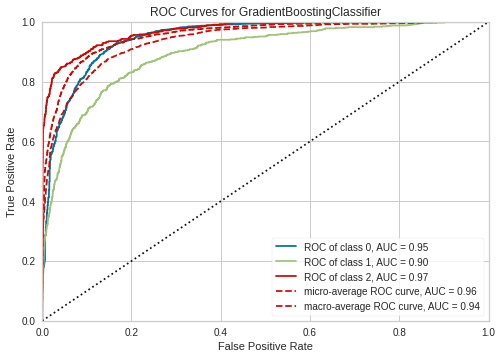

In [ ]:
# Plotting the AUC
plot_model(estimator = gbc, plot = 'auc')


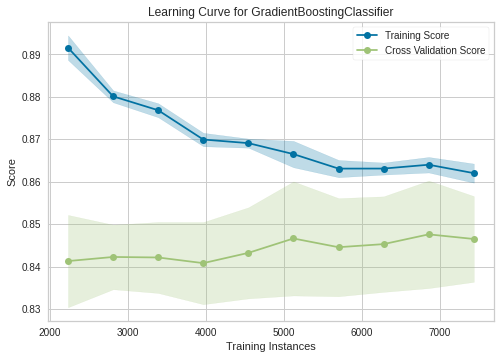

In [ ]:
# Plotting the learning curve
plot_model(estimator = gbc, plot = 'learning' )

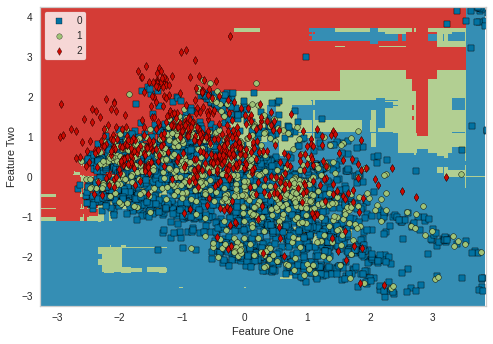

In [ ]:
plot_model(estimator = gbc, plot='boundary')

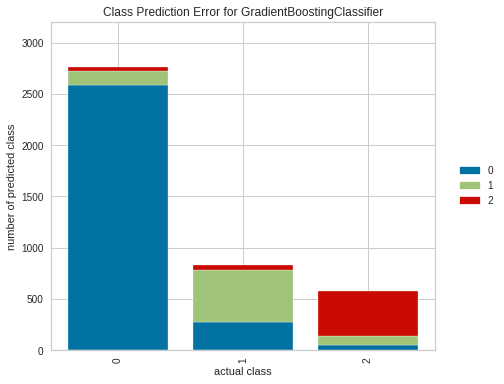

In [ ]:
plot_model(estimator = gbc, plot = 'error')

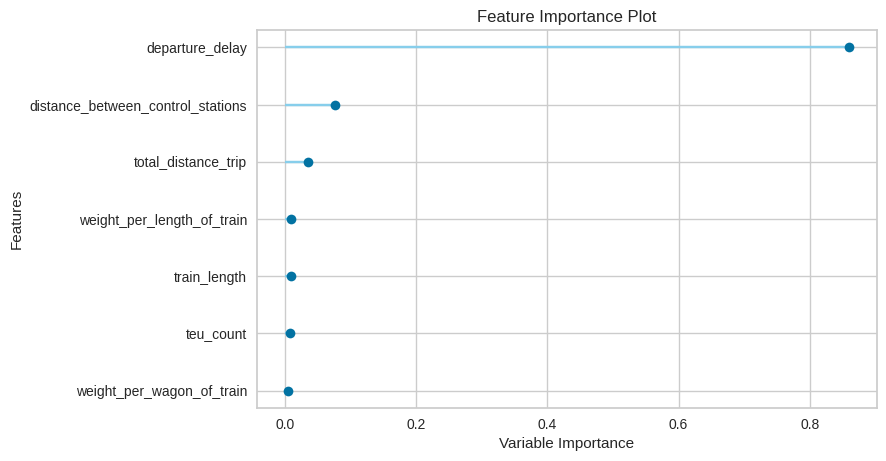

In [ ]:
# Plotting the feature importance
plot_model(estimator = gbc, plot = 'feature')

In [ ]:
predict_model(estimator = gbc)

teu_count  train_length  total_distance_trip  departure_delay  \
0      0.406323      0.051765             1.002504        -0.488159   
1      0.514384      0.051765             1.006070        -0.018996   
2      1.230466      0.721051            -1.051822        -0.813615   
3      1.366863      1.107750             0.367039         0.226153   
4     -0.025920      0.051765             1.084600         1.012318   
...         ...           ...                  ...              ...   
4164  -0.842380     -0.528283            -0.828578        -0.327544   
4165  -0.065783      0.557448            -0.430341         0.205019   
4166   0.082140     -0.201076             1.076885         0.792530   
4167   1.270809      0.810290             0.537247         3.472256   
4168  -0.348662     -0.409299            -0.872259        -0.137343   

      distance_between_control_stations  weight_per_length_of_train  \
0                             -0.014466                   -0.368629   
1                              1.321425                   -1.460856   
2                             -0.162580                    2.611649   
3                              0.019715                    0.732620   
4                             -0.515308                   -0.200062   
...                                 ...                         ...   
4164                          -0.643130                   -0.603645   
4165                           0.278530                    0.884650   
4166                           1.321425                    0.103452   
4167                          -0.718950                    0.935154   
4168                          -0.165455                   -0.420958   

      weight_per_wagon_of_train     arrived       Label   Score  
0                      0.065276   0_on_time   0_on_time  0.9084  
1                     -1.110715   0_on_time   0_on_time  0.3765  
2                      0.202914   0_on_time   0_on_time  0.7694  
3                      1.041691      1_late      1_late  0.8613  
4                      0.246771  2_too_late  2_too_late  0.9720  
...                         ...         ...         ...     ...  
4164                  -0.524077   0_on_time   0_on_time  0.9431  
4165                   1.414672      1_late      1_late  0.6005  
4166                   0.573563      1_late  2_too_late  0.7760  
4167                   1.469049  2_too_late  2_too_late  0.9940  
4168                  -0.215883   0_on_time      1_late  0.5184  

[4169 rows x 10 columns]

## Tuned gbc

In [ ]:
# tune hyperparameters to optimize AUC
tuned_gbc = tune_model(estimator = gbc, optimize = 'AUC', n_iter=80) #default is 'Accuracy'

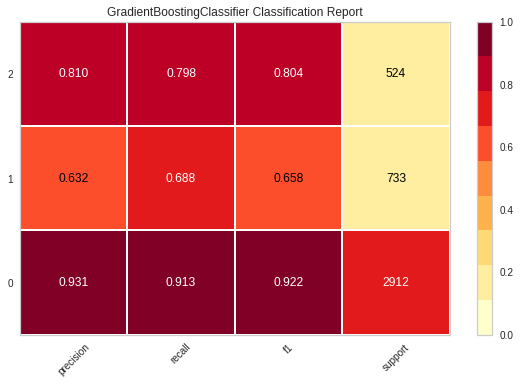

In [ ]:
# Plotting the classification report
plot_model(estimator = tuned_gbc, plot = 'class_report')

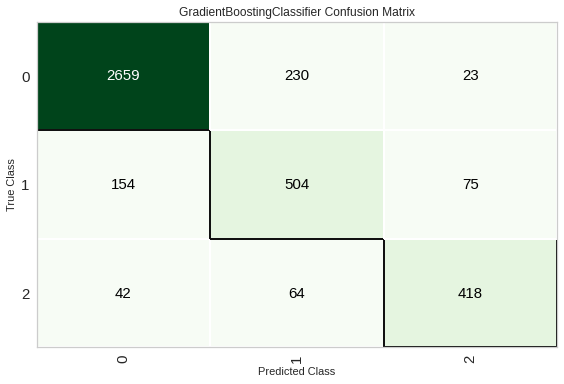

In [ ]:
# Plotting the confusion matrix
plot_model(estimator = tuned_gbc, plot = 'confusion_matrix')

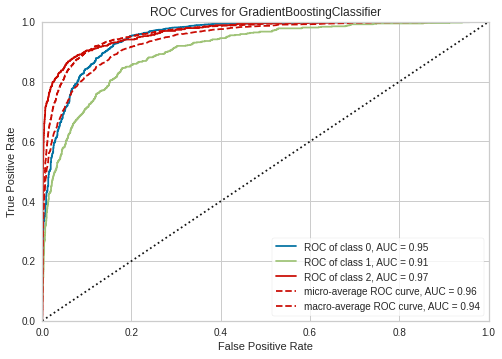

In [ ]:
# Plotting the AUC
plot_model(estimator = tuned_gbc, plot = 'auc')


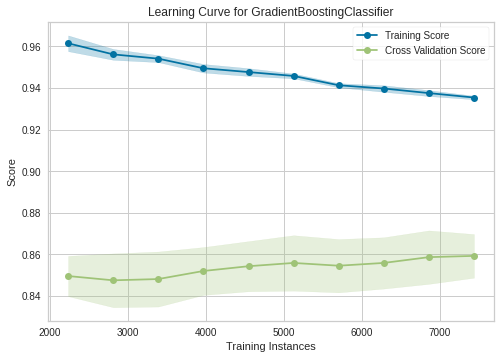

In [ ]:
# Plotting the learning curve
plot_model(estimator = tuned_gbc, plot = 'learning' )

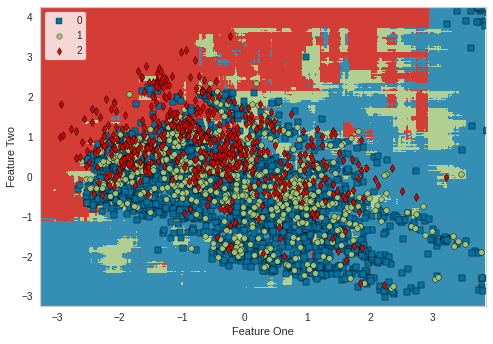

In [ ]:
plot_model(estimator = tuned_gbc, plot='boundary')

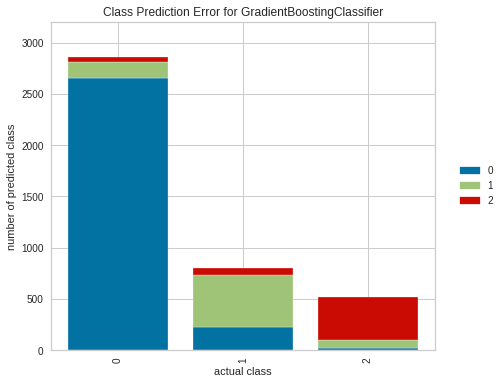

In [ ]:
plot_model(estimator = tuned_gbc, plot = 'error')

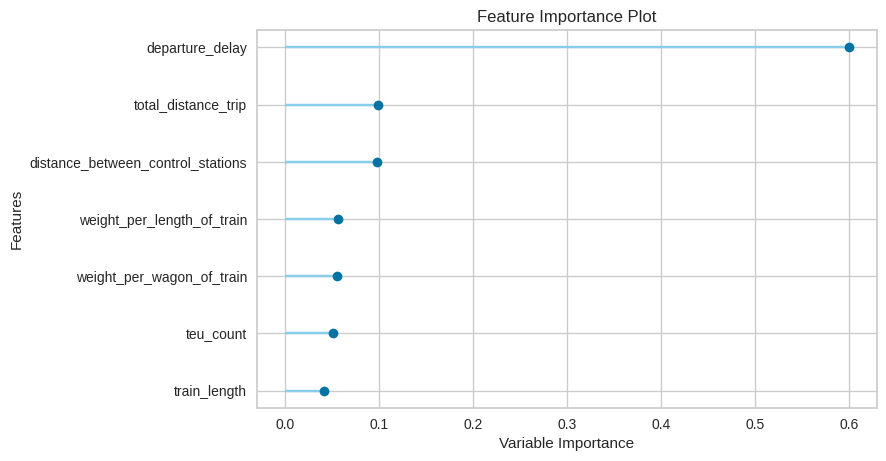

In [ ]:
# Plotting the feature importance
plot_model(estimator = tuned_gbc, plot = 'feature')

In [ ]:
predict_model(estimator = tuned_gbc)

teu_count  train_length  total_distance_trip  departure_delay  \
0      0.406323      0.051765             1.002504        -0.488159   
1      0.514384      0.051765             1.006070        -0.018996   
2      1.230466      0.721051            -1.051822        -0.813615   
3      1.366863      1.107750             0.367039         0.226153   
4     -0.025920      0.051765             1.084600         1.012318   
...         ...           ...                  ...              ...   
4164  -0.842380     -0.528283            -0.828578        -0.327544   
4165  -0.065783      0.557448            -0.430341         0.205019   
4166   0.082140     -0.201076             1.076885         0.792530   
4167   1.270809      0.810290             0.537247         3.472256   
4168  -0.348662     -0.409299            -0.872259        -0.137343   

      distance_between_control_stations  weight_per_length_of_train  \
0                             -0.014466                   -0.368629   
1                              1.321425                   -1.460856   
2                             -0.162580                    2.611649   
3                              0.019715                    0.732620   
4                             -0.515308                   -0.200062   
...                                 ...                         ...   
4164                          -0.643130                   -0.603645   
4165                           0.278530                    0.884650   
4166                           1.321425                    0.103452   
4167                          -0.718950                    0.935154   
4168                          -0.165455                   -0.420958   

      weight_per_wagon_of_train     arrived       Label   Score  
0                      0.065276   0_on_time   0_on_time  0.8392  
1                     -1.110715   0_on_time   0_on_time  0.5776  
2                      0.202914   0_on_time   0_on_time  0.6777  
3                      1.041691      1_late      1_late  0.8053  
4                      0.246771  2_too_late  2_too_late  0.9241  
...                         ...         ...         ...     ...  
4164                  -0.524077   0_on_time   0_on_time  0.9270  
4165                   1.414672      1_late      1_late  0.5433  
4166                   0.573563      1_late  2_too_late  0.5617  
4167                   1.469049  2_too_late  2_too_late  0.8612  
4168                  -0.215883   0_on_time      1_late  0.4912  

[4169 rows x 10 columns]

## lightgbm

In [ ]:
# Best ML analysis
lightgbm = create_model('lightgbm')

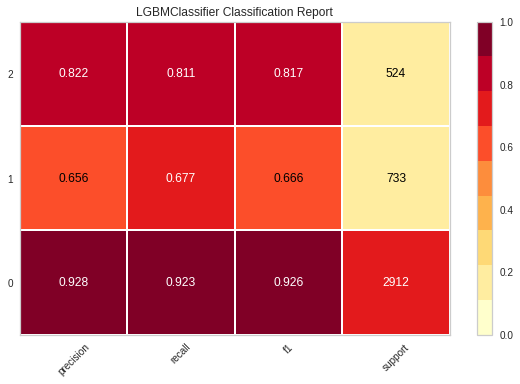

In [ ]:
# Plotting the classification report
plot_model(estimator = lightgbm, plot = 'class_report')

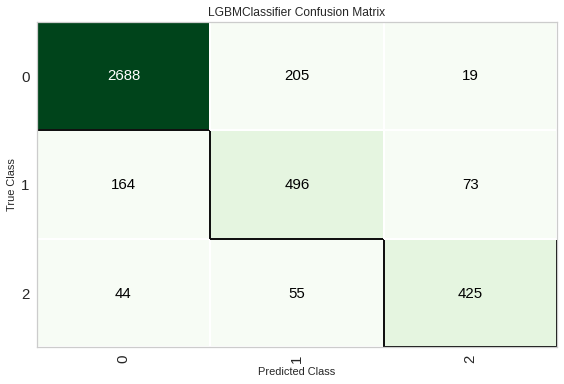

In [ ]:
# Plotting the confusion matrix
plot_model(estimator = lightgbm, plot = 'confusion_matrix')

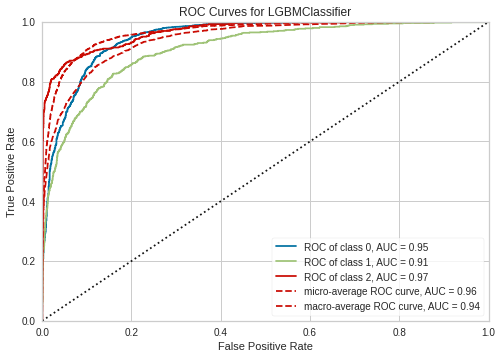

In [ ]:
# Plotting the AUC
plot_model(estimator = lightgbm, plot = 'auc')


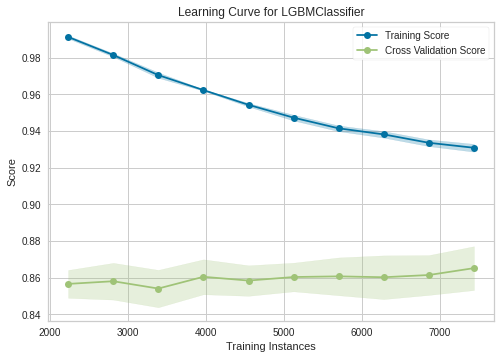

In [ ]:
# Plotting the learning curve
plot_model(estimator = lightgbm, plot = 'learning' )

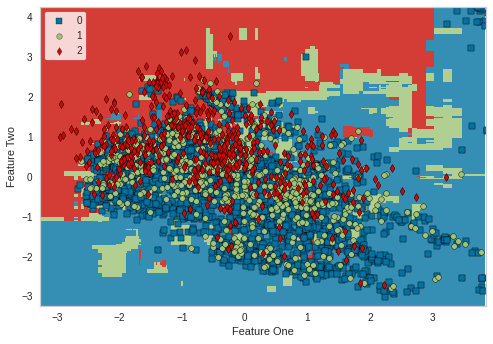

In [ ]:
plot_model(estimator = lightgbm, plot='boundary')

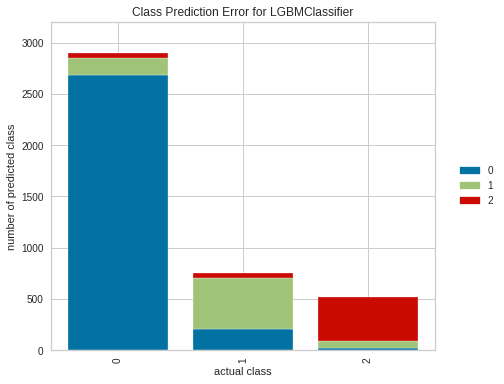

In [ ]:
plot_model(estimator = lightgbm, plot = 'error')

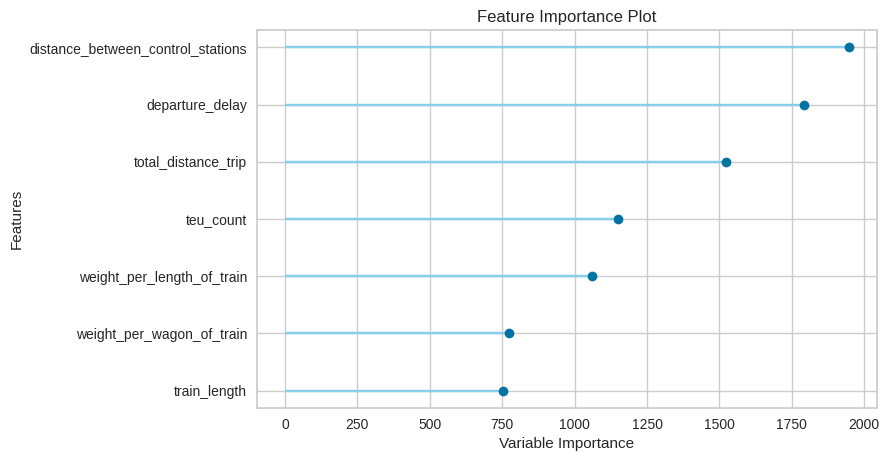

In [ ]:
# Plotting the feature importance
plot_model(estimator = lightgbm, plot = 'feature')

C extension was not built during install!


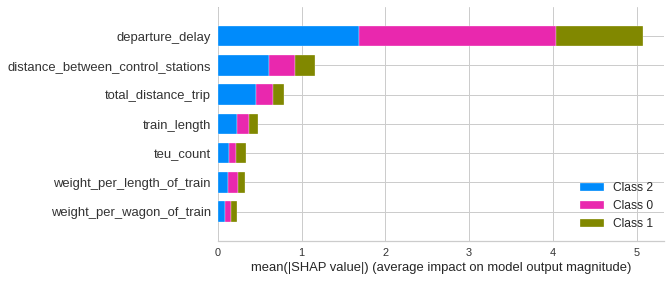

In [ ]:
interpret_model(estimator = lightgbm)

In [ ]:
predict_model(estimator = lightgbm)

teu_count  train_length  total_distance_trip  departure_delay  \
0      0.406323      0.051765             1.002504        -0.488159   
1      0.514384      0.051765             1.006070        -0.018996   
2      1.230466      0.721051            -1.051822        -0.813615   
3      1.366863      1.107750             0.367039         0.226153   
4     -0.025920      0.051765             1.084600         1.012318   
...         ...           ...                  ...              ...   
4164  -0.842380     -0.528283            -0.828578        -0.327544   
4165  -0.065783      0.557448            -0.430341         0.205019   
4166   0.082140     -0.201076             1.076885         0.792530   
4167   1.270809      0.810290             0.537247         3.472256   
4168  -0.348662     -0.409299            -0.872259        -0.137343   

      distance_between_control_stations  weight_per_length_of_train  \
0                             -0.014466                   -0.368629   
1                              1.321425                   -1.460856   
2                             -0.162580                    2.611649   
3                              0.019715                    0.732620   
4                             -0.515308                   -0.200062   
...                                 ...                         ...   
4164                          -0.643130                   -0.603645   
4165                           0.278530                    0.884650   
4166                           1.321425                    0.103452   
4167                          -0.718950                    0.935154   
4168                          -0.165455                   -0.420958   

      weight_per_wagon_of_train     arrived       Label   Score  
0                      0.065276   0_on_time   0_on_time  0.9341  
1                     -1.110715   0_on_time   0_on_time  0.4206  
2                      0.202914   0_on_time   0_on_time  0.8121  
3                      1.041691      1_late      1_late  0.9517  
4                      0.246771  2_too_late  2_too_late  0.9971  
...                         ...         ...         ...     ...  
4164                  -0.524077   0_on_time   0_on_time  0.9863  
4165                   1.414672      1_late      1_late  0.5175  
4166                   0.573563      1_late  2_too_late  0.5389  
4167                   1.469049  2_too_late  2_too_late  0.9888  
4168                  -0.215883   0_on_time      1_late  0.6074  

[4169 rows x 10 columns]

## Tuned lightgbm

In [ ]:
# tune hyperparameters to optimize AUC
tuned_lightgbm = tune_model(estimator = lightgbm, optimize = 'AUC', n_iter=80) #default is 'Accuracy'

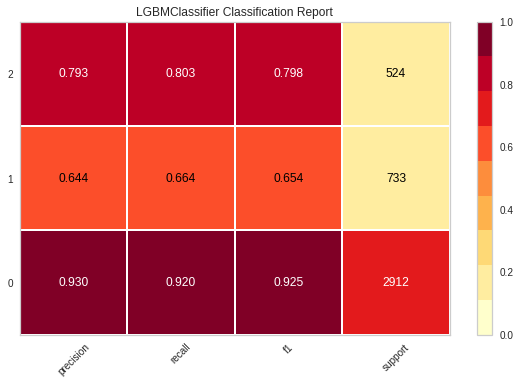

In [ ]:
# Plotting the classification report
plot_model(estimator = tuned_lightgbm, plot = 'class_report')

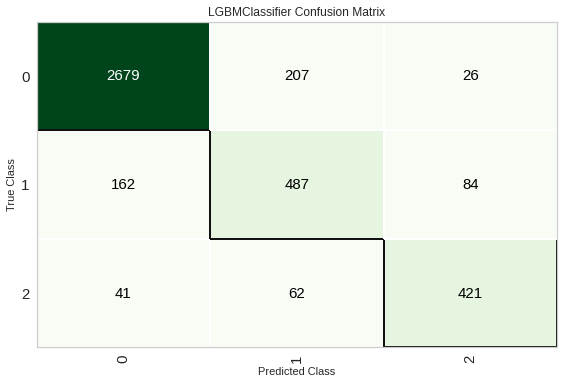

In [ ]:
# Plotting the confusion matrix
plot_model(estimator = tuned_lightgbm, plot = 'confusion_matrix')

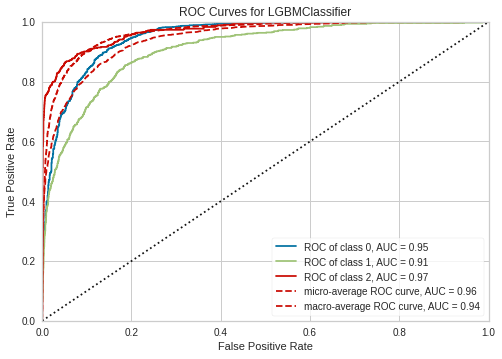

In [ ]:
# Plotting the AUC
plot_model(estimator = tuned_lightgbm, plot = 'auc')


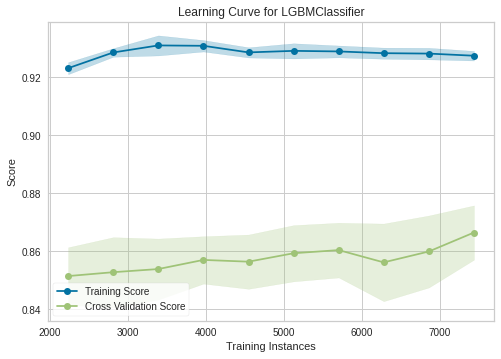

In [ ]:
# Plotting the learning curve
plot_model(estimator = tuned_lightgbm, plot = 'learning' )

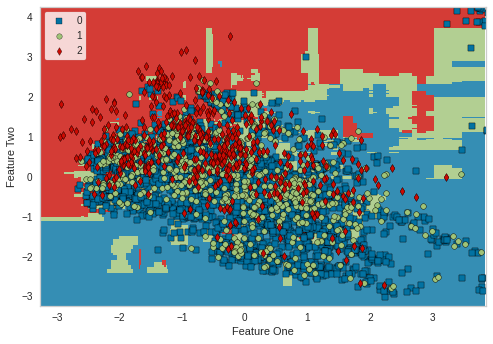

In [ ]:
plot_model(estimator = tuned_lightgbm, plot='boundary')

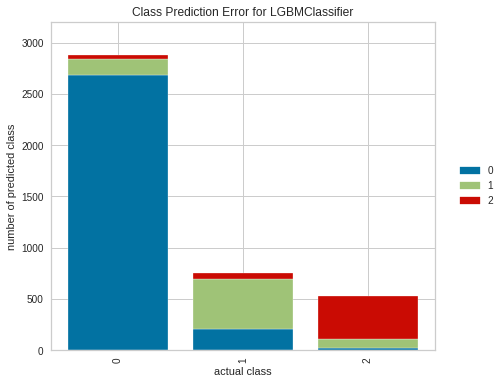

In [ ]:
plot_model(estimator = tuned_lightgbm, plot = 'error')

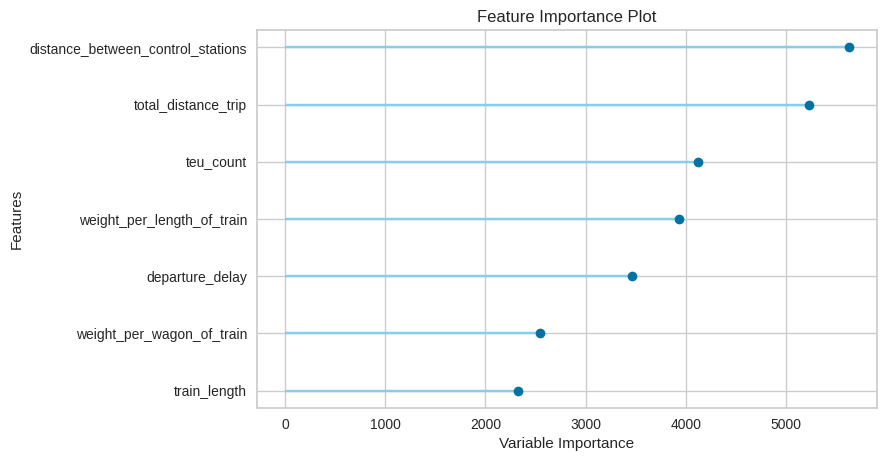

In [ ]:
# Plotting the feature importance
plot_model(estimator = tuned_lightgbm, plot = 'feature')

C extension was not built during install!


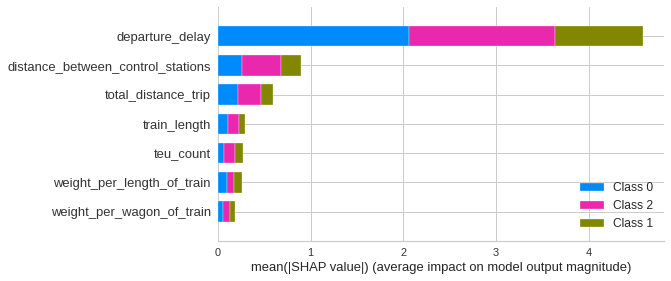

In [ ]:
interpret_model(estimator = tuned_lightgbm)

In [ ]:
predict_model(estimator = tuned_lightgbm)

teu_count  train_length  total_distance_trip  departure_delay  \
0      0.406323      0.051765             1.002504        -0.488159   
1      0.514384      0.051765             1.006070        -0.018996   
2      1.230466      0.721051            -1.051822        -0.813615   
3      1.366863      1.107750             0.367039         0.226153   
4     -0.025920      0.051765             1.084600         1.012318   
...         ...           ...                  ...              ...   
4164  -0.842380     -0.528283            -0.828578        -0.327544   
4165  -0.065783      0.557448            -0.430341         0.205019   
4166   0.082140     -0.201076             1.076885         0.792530   
4167   1.270809      0.810290             0.537247         3.472256   
4168  -0.348662     -0.409299            -0.872259        -0.137343   

      distance_between_control_stations  weight_per_length_of_train  \
0                             -0.014466                   -0.368629   
1                              1.321425                   -1.460856   
2                             -0.162580                    2.611649   
3                              0.019715                    0.732620   
4                             -0.515308                   -0.200062   
...                                 ...                         ...   
4164                          -0.643130                   -0.603645   
4165                           0.278530                    0.884650   
4166                           1.321425                    0.103452   
4167                          -0.718950                    0.935154   
4168                          -0.165455                   -0.420958   

      weight_per_wagon_of_train     arrived       Label   Score  
0                      0.065276   0_on_time   0_on_time  0.9556  
1                     -1.110715   0_on_time   0_on_time  0.4970  
2                      0.202914   0_on_time   0_on_time  0.8968  
3                      1.041691      1_late      1_late  0.9207  
4                      0.246771  2_too_late  2_too_late  0.9926  
...                         ...         ...         ...     ...  
4164                  -0.524077   0_on_time   0_on_time  0.9931  
4165                   1.414672      1_late      1_late  0.5190  
4166                   0.573563      1_late  2_too_late  0.7464  
4167                   1.469049  2_too_late  2_too_late  0.9849  
4168                  -0.215883   0_on_time   0_on_time  0.5398  

[4169 rows x 10 columns]

## catboost

In [ ]:
# Best ML analysis
catboost = create_model('catboost')

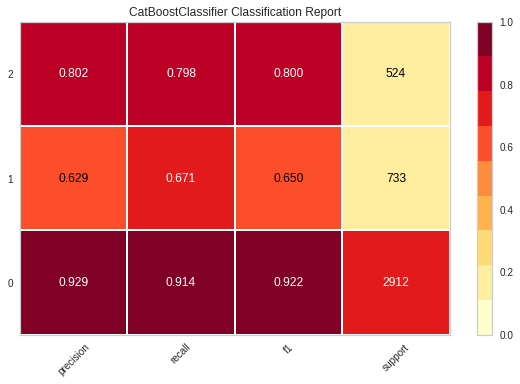

In [ ]:
# Plotting the classification report
plot_model(estimator = catboost, plot = 'class_report')

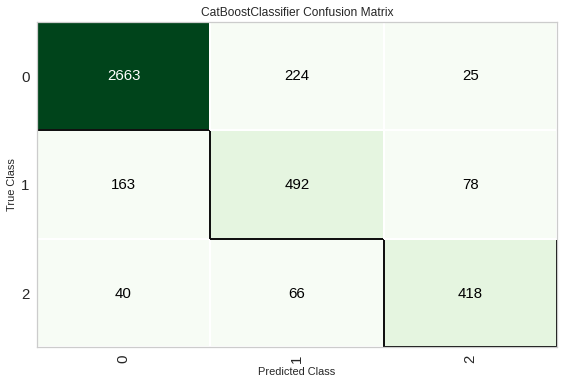

In [ ]:
# Plotting the confusion matrix
plot_model(estimator = catboost, plot = 'confusion_matrix')

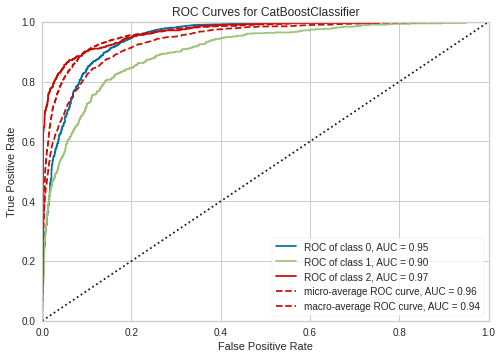

In [ ]:
# Plotting the AUC
plot_model(estimator = catboost, plot = 'auc')


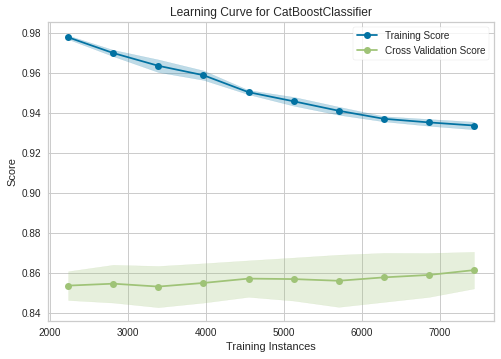

In [ ]:
# Plotting the learning curve
plot_model(estimator = catboost, plot = 'learning' )

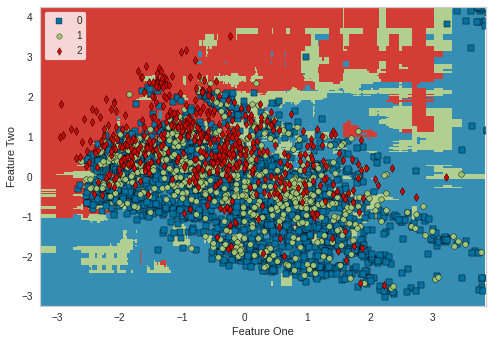

In [ ]:
plot_model(estimator = catboost, plot='boundary')

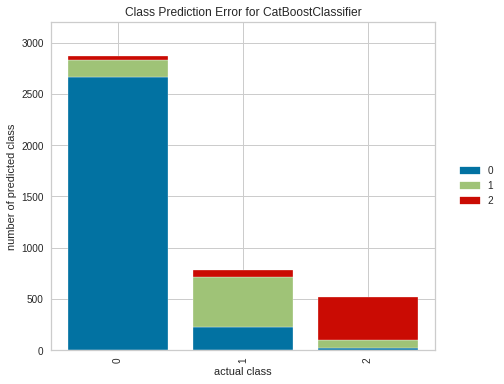

In [ ]:
plot_model(estimator = catboost, plot = 'error')

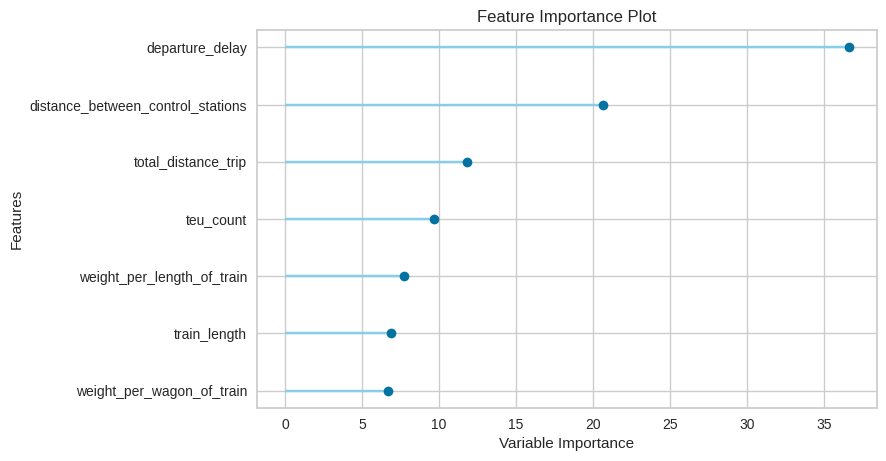

In [ ]:
# Plotting the feature importance
plot_model(estimator = catboost, plot = 'feature')

C extension was not built during install!


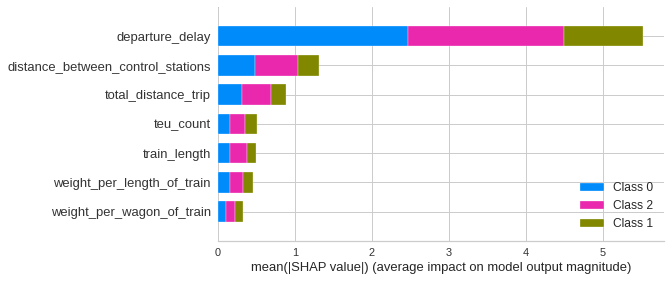

In [ ]:
interpret_model(estimator = catboost)

In [ ]:
predict_model(estimator = catboost)

teu_count  train_length  total_distance_trip  departure_delay  \
0      0.406323      0.051765             1.002504        -0.488159   
1      0.514384      0.051765             1.006070        -0.018996   
2      1.230466      0.721051            -1.051822        -0.813615   
3      1.366863      1.107750             0.367039         0.226153   
4     -0.025920      0.051765             1.084600         1.012318   
...         ...           ...                  ...              ...   
4164  -0.842380     -0.528283            -0.828578        -0.327544   
4165  -0.065783      0.557448            -0.430341         0.205019   
4166   0.082140     -0.201076             1.076885         0.792530   
4167   1.270809      0.810290             0.537247         3.472256   
4168  -0.348662     -0.409299            -0.872259        -0.137343   

      distance_between_control_stations  weight_per_length_of_train  \
0                             -0.014466                   -0.368629   
1                              1.321425                   -1.460856   
2                             -0.162580                    2.611649   
3                              0.019715                    0.732620   
4                             -0.515308                   -0.200062   
...                                 ...                         ...   
4164                          -0.643130                   -0.603645   
4165                           0.278530                    0.884650   
4166                           1.321425                    0.103452   
4167                          -0.718950                    0.935154   
4168                          -0.165455                   -0.420958   

      weight_per_wagon_of_train     arrived       Label   Score  
0                      0.065276   0_on_time   0_on_time  0.9346  
1                     -1.110715   0_on_time   0_on_time  0.6298  
2                      0.202914   0_on_time   0_on_time  0.9262  
3                      1.041691      1_late      1_late  0.8912  
4                      0.246771  2_too_late  2_too_late  0.9983  
...                         ...         ...         ...     ...  
4164                  -0.524077   0_on_time   0_on_time  0.9967  
4165                   1.414672      1_late      1_late  0.5403  
4166                   0.573563      1_late  2_too_late  0.7932  
4167                   1.469049  2_too_late  2_too_late  0.9966  
4168                  -0.215883   0_on_time      1_late  0.5069  

[4169 rows x 10 columns]

## Tuned catboost

In [ ]:
# tune hyperparameters to optimize AUC
tuned_catboost = tune_model(estimator = catboost, optimize = 'AUC', n_iter=40) #default is 'Accuracy'

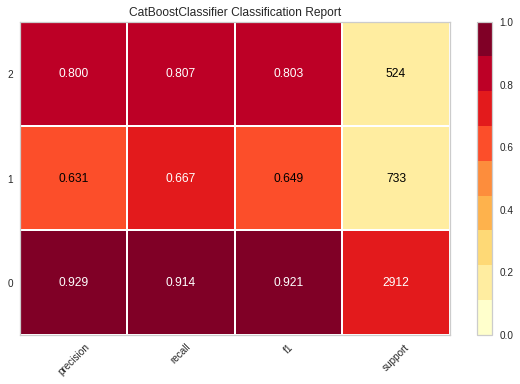

In [ ]:
# Plotting the classification report
plot_model(estimator = tuned_catboost, plot = 'class_report')

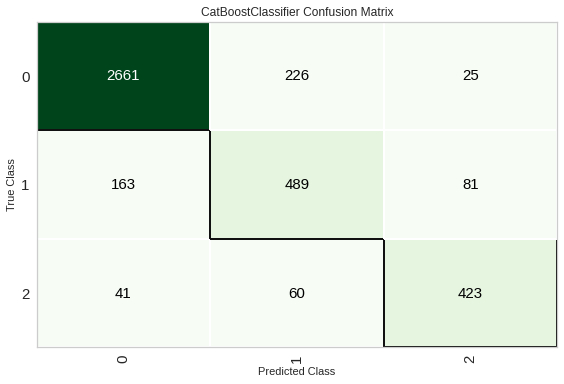

In [ ]:
# Plotting the confusion matrix
plot_model(estimator = tuned_catboost, plot = 'confusion_matrix')

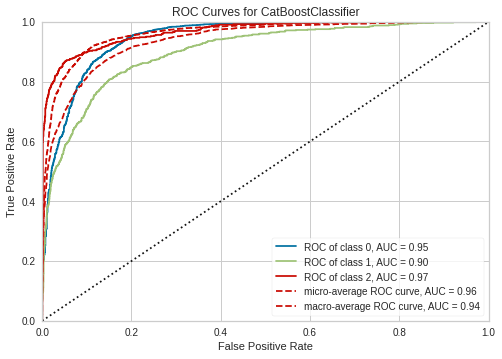

In [ ]:
# Plotting the AUC
plot_model(estimator = tuned_catboost, plot = 'auc')


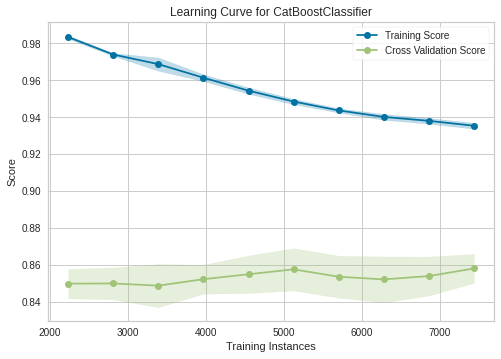

In [ ]:
# Plotting the learning curve
plot_model(estimator = tuned_catboost, plot = 'learning' )

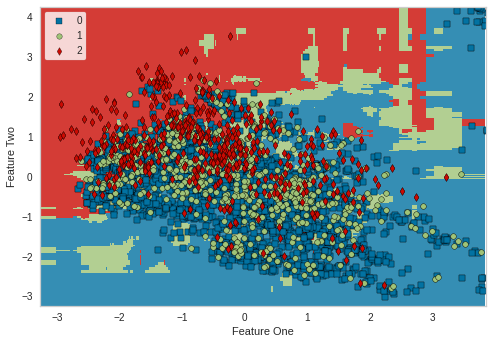

In [ ]:
plot_model(estimator = tuned_catboost, plot='boundary')

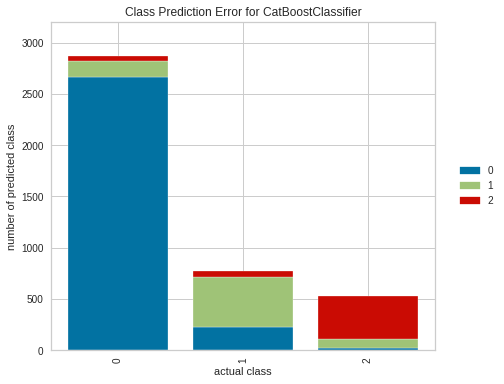

In [ ]:
plot_model(estimator = tuned_catboost, plot = 'error')

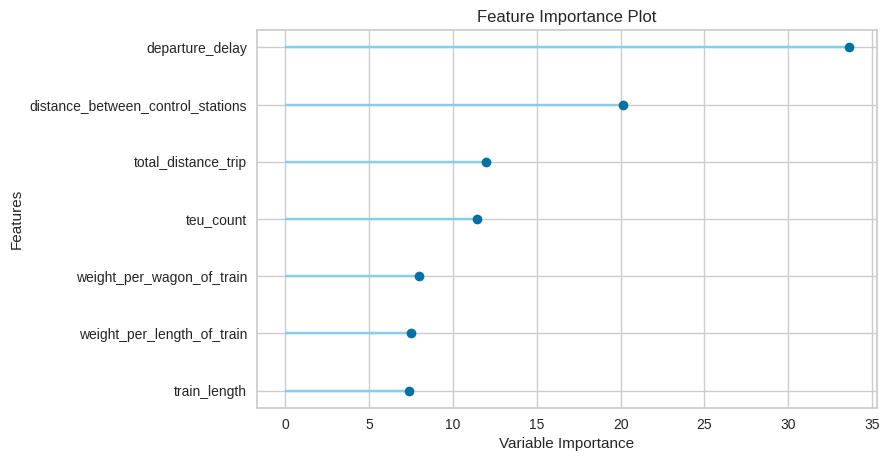

In [ ]:
# Plotting the feature importance
plot_model(estimator = tuned_catboost, plot = 'feature')

C extension was not built during install!


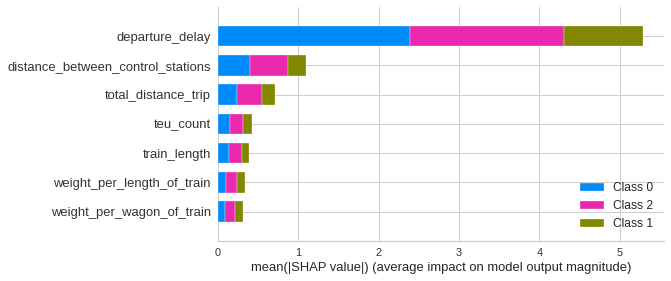

In [ ]:
interpret_model(estimator = tuned_catboost)

In [ ]:
predict_model(estimator = tuned_catboost)

teu_count  train_length  total_distance_trip  departure_delay  \
0      0.406323      0.051765             1.002504        -0.488159   
1      0.514384      0.051765             1.006070        -0.018996   
2      1.230466      0.721051            -1.051822        -0.813615   
3      1.366863      1.107750             0.367039         0.226153   
4     -0.025920      0.051765             1.084600         1.012318   
...         ...           ...                  ...              ...   
4164  -0.842380     -0.528283            -0.828578        -0.327544   
4165  -0.065783      0.557448            -0.430341         0.205019   
4166   0.082140     -0.201076             1.076885         0.792530   
4167   1.270809      0.810290             0.537247         3.472256   
4168  -0.348662     -0.409299            -0.872259        -0.137343   

      distance_between_control_stations  weight_per_length_of_train  \
0                             -0.014466                   -0.368629   
1                              1.321425                   -1.460856   
2                             -0.162580                    2.611649   
3                              0.019715                    0.732620   
4                             -0.515308                   -0.200062   
...                                 ...                         ...   
4164                          -0.643130                   -0.603645   
4165                           0.278530                    0.884650   
4166                           1.321425                    0.103452   
4167                          -0.718950                    0.935154   
4168                          -0.165455                   -0.420958   

      weight_per_wagon_of_train     arrived       Label   Score  
0                      0.065276   0_on_time   0_on_time  0.9180  
1                     -1.110715   0_on_time   0_on_time  0.6615  
2                      0.202914   0_on_time   0_on_time  0.9298  
3                      1.041691      1_late      1_late  0.8355  
4                      0.246771  2_too_late  2_too_late  0.9964  
...                         ...         ...         ...     ...  
4164                  -0.524077   0_on_time   0_on_time  0.9967  
4165                   1.414672      1_late      1_late  0.7812  
4166                   0.573563      1_late  2_too_late  0.6204  
4167                   1.469049  2_too_late  2_too_late  0.9933  
4168                  -0.215883   0_on_time   0_on_time  0.5275  

[4169 rows x 10 columns]

## rf

In [ ]:
# Best ML analysis
rf = create_model('rf')

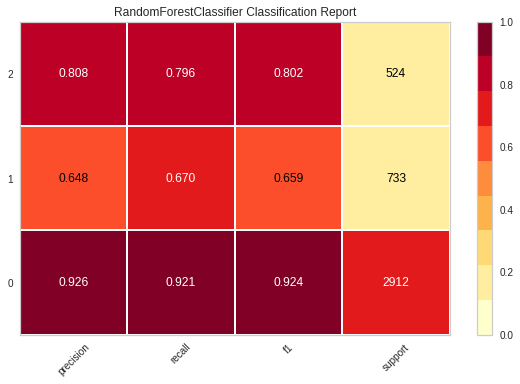

In [ ]:
# Plotting the classification report
plot_model(estimator = rf, plot = 'class_report')

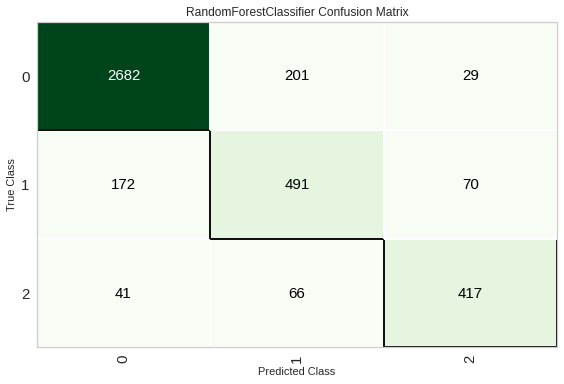

In [ ]:
# Plotting the confusion matrix
plot_model(estimator = rf, plot = 'confusion_matrix')

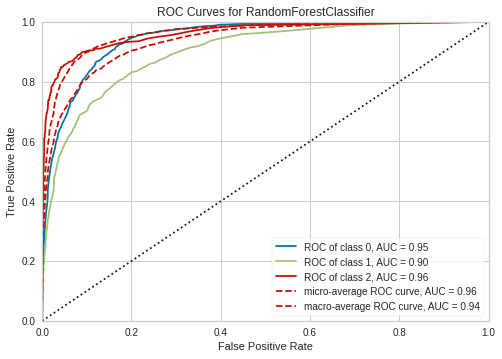

In [ ]:
# Plotting the AUC
plot_model(estimator = rf, plot = 'auc')


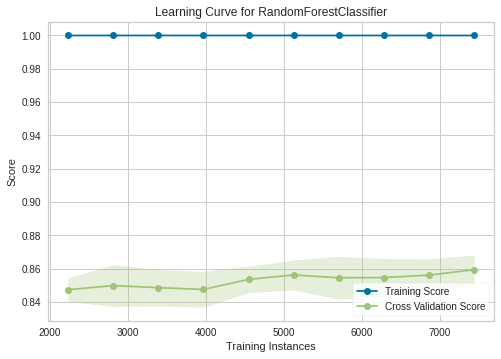

In [ ]:
# Plotting the learning curve
plot_model(estimator = rf, plot = 'learning' )

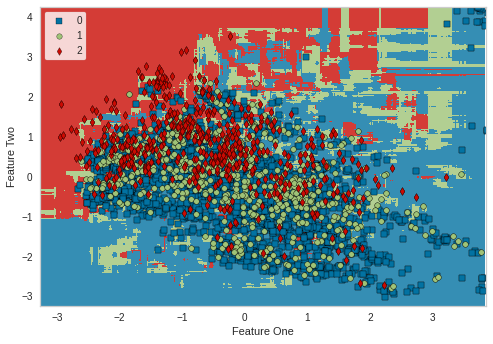

In [ ]:
plot_model(estimator = rf, plot='boundary')

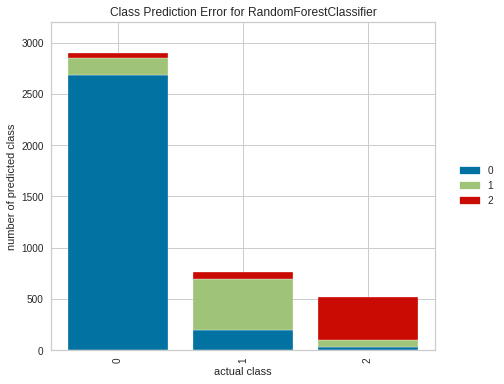

In [ ]:
plot_model(estimator = rf, plot = 'error')

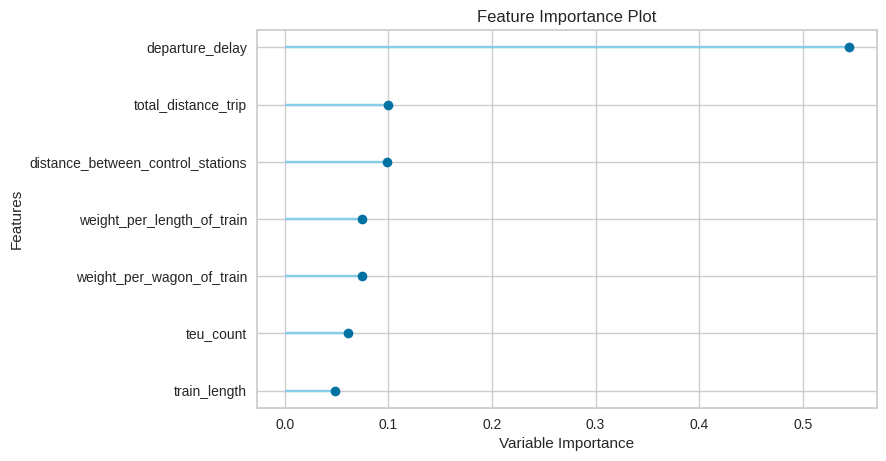

In [ ]:
# Plotting the feature importance
plot_model(estimator = rf, plot = 'feature')

interpret_model(estimator = rf)

In [ ]:
predict_model(estimator = rf)

teu_count  train_length  total_distance_trip  departure_delay  \
0      0.406323      0.051765             1.002504        -0.488159   
1      0.514384      0.051765             1.006070        -0.018996   
2      1.230466      0.721051            -1.051822        -0.813615   
3      1.366863      1.107750             0.367039         0.226153   
4     -0.025920      0.051765             1.084600         1.012318   
...         ...           ...                  ...              ...   
4164  -0.842380     -0.528283            -0.828578        -0.327544   
4165  -0.065783      0.557448            -0.430341         0.205019   
4166   0.082140     -0.201076             1.076885         0.792530   
4167   1.270809      0.810290             0.537247         3.472256   
4168  -0.348662     -0.409299            -0.872259        -0.137343   

      distance_between_control_stations  weight_per_length_of_train  \
0                             -0.014466                   -0.368629   
1                              1.321425                   -1.460856   
2                             -0.162580                    2.611649   
3                              0.019715                    0.732620   
4                             -0.515308                   -0.200062   
...                                 ...                         ...   
4164                          -0.643130                   -0.603645   
4165                           0.278530                    0.884650   
4166                           1.321425                    0.103452   
4167                          -0.718950                    0.935154   
4168                          -0.165455                   -0.420958   

      weight_per_wagon_of_train     arrived       Label  Score  
0                      0.065276   0_on_time   0_on_time   0.93  
1                     -1.110715   0_on_time   0_on_time   0.75  
2                      0.202914   0_on_time   0_on_time   0.60  
3                      1.041691      1_late      1_late   0.84  
4                      0.246771  2_too_late  2_too_late   0.97  
...                         ...         ...         ...    ...  
4164                  -0.524077   0_on_time   0_on_time   1.00  
4165                   1.414672      1_late      1_late   0.46  
4166                   0.573563      1_late      1_late   0.51  
4167                   1.469049  2_too_late  2_too_late   0.82  
4168                  -0.215883   0_on_time   0_on_time   0.54  

[4169 rows x 10 columns]

## Tuned rf

In [ ]:
# tune hyperparameters to optimize AUC
tuned_rf = tune_model(estimator = rf, optimize = 'auc', n_iter=90) #default is 'Accuracy'

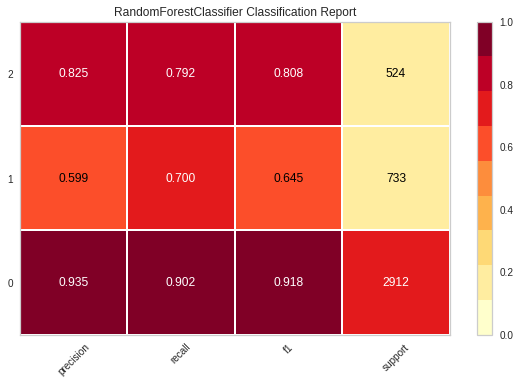

In [ ]:
# Plotting the classification report
plot_model(estimator = tuned_rf, plot = 'class_report')

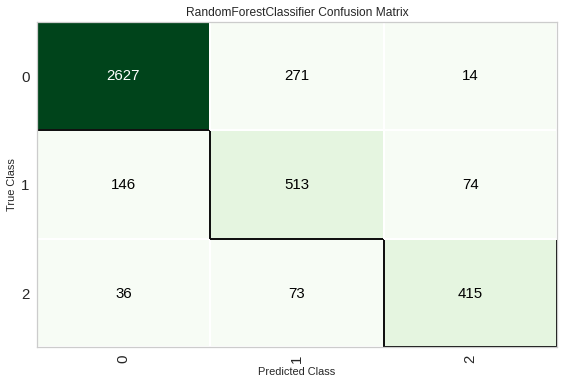

In [ ]:
# Plotting the confusion matrix
plot_model(estimator = tuned_rf, plot = 'confusion_matrix')

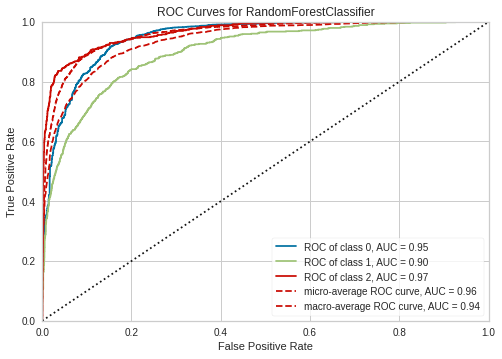

In [ ]:
# Plotting the AUC
plot_model(estimator = tuned_rf, plot = 'auc')


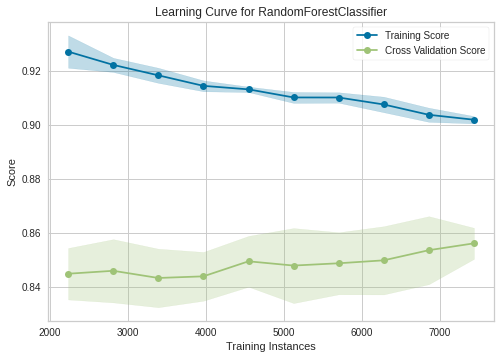

In [ ]:
# Plotting the learning curve
plot_model(estimator = tuned_rf, plot = 'learning' )

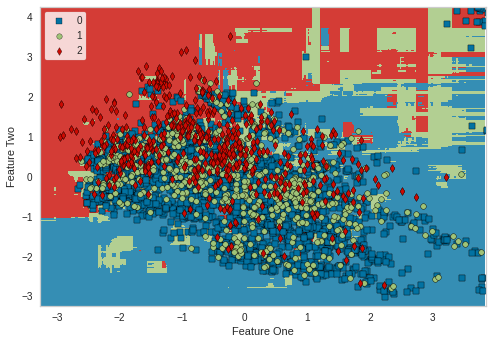

In [ ]:
plot_model(estimator = tuned_rf, plot='boundary')

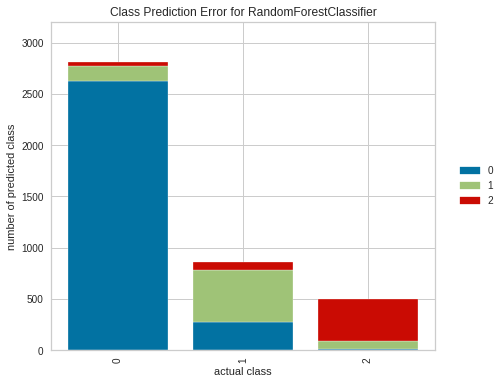

In [ ]:
plot_model(estimator = tuned_rf, plot = 'error')

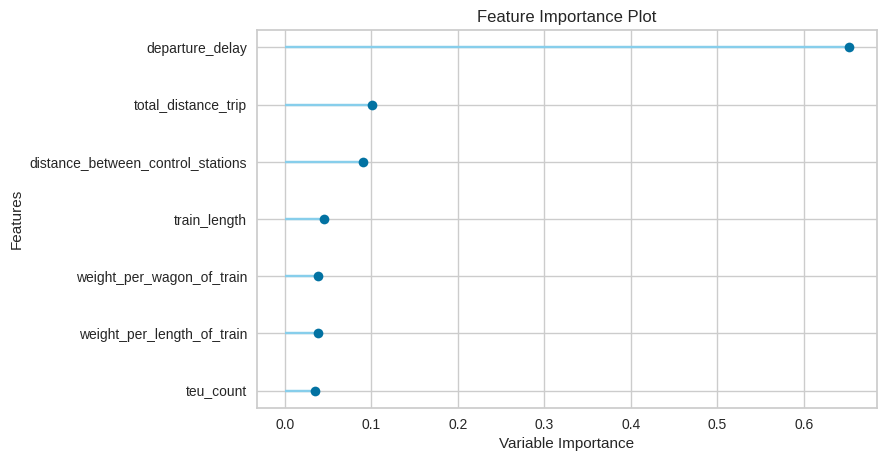

In [ ]:
# Plotting the feature importance
plot_model(estimator = tuned_rf, plot = 'feature')

interpret_model(estimator = tuned_rf)

In [ ]:
predict_model(estimator = tuned_rf)

teu_count  train_length  total_distance_trip  departure_delay  \
0      0.406323      0.051765             1.002504        -0.488159   
1      0.514384      0.051765             1.006070        -0.018996   
2      1.230466      0.721051            -1.051822        -0.813615   
3      1.366863      1.107750             0.367039         0.226153   
4     -0.025920      0.051765             1.084600         1.012318   
...         ...           ...                  ...              ...   
4164  -0.842380     -0.528283            -0.828578        -0.327544   
4165  -0.065783      0.557448            -0.430341         0.205019   
4166   0.082140     -0.201076             1.076885         0.792530   
4167   1.270809      0.810290             0.537247         3.472256   
4168  -0.348662     -0.409299            -0.872259        -0.137343   

      distance_between_control_stations  weight_per_length_of_train  \
0                             -0.014466                   -0.368629   
1                              1.321425                   -1.460856   
2                             -0.162580                    2.611649   
3                              0.019715                    0.732620   
4                             -0.515308                   -0.200062   
...                                 ...                         ...   
4164                          -0.643130                   -0.603645   
4165                           0.278530                    0.884650   
4166                           1.321425                    0.103452   
4167                          -0.718950                    0.935154   
4168                          -0.165455                   -0.420958   

      weight_per_wagon_of_train     arrived       Label   Score  
0                      0.065276   0_on_time   0_on_time  0.7361  
1                     -1.110715   0_on_time      1_late  0.3901  
2                      0.202914   0_on_time   0_on_time  0.7365  
3                      1.041691      1_late      1_late  0.8276  
4                      0.246771  2_too_late  2_too_late  0.9659  
...                         ...         ...         ...     ...  
4164                  -0.524077   0_on_time   0_on_time  0.9883  
4165                   1.414672      1_late      1_late  0.6218  
4166                   0.573563      1_late  2_too_late  0.6989  
4167                   1.469049  2_too_late  2_too_late  0.7573  
4168                  -0.215883   0_on_time   0_on_time  0.4844  

[4169 rows x 10 columns]

# Saving the models

In [ ]:
help(get_config)

Help on function get_config in module pycaret.classification:

get_config(variable: str)
    This function retrieves the global variables created when initializing the 
    ``setup`` function. Following variables are accessible:
    
    - X: Transformed dataset (X)
    - y: Transformed dataset (y)  
    - X_train: Transformed train dataset (X)
    - X_test: Transformed test/holdout dataset (X)
    - y_train: Transformed train dataset (y)
    - y_test: Transformed test/holdout dataset (y)
    - seed: random state set through session_id
    - prep_pipe: Transformation pipeline
    - fold_shuffle_param: shuffle parameter used in Kfolds
    - n_jobs_param: n_jobs parameter used in model training
    - html_param: html_param configured through setup
    - create_model_container: results grid storage container
    - master_model_container: model storage container
    - display_container: results display container
    - exp_name_log: Name of experiment
    - logging_param: log_experiment par

In [ ]:
get_config('X_test')

teu_count  train_length  total_distance_trip  departure_delay  \
13474   0.406323      0.051765             1.002504        -0.488159   
2737    0.514384      0.051765             1.006070        -0.018996   
10731   1.230466      0.721051            -1.051822        -0.813615   
6061    1.366863      1.107750             0.367039         0.226153   
4490   -0.025920      0.051765             1.084600         1.012318   
...          ...           ...                  ...              ...   
11296  -0.842380     -0.528283            -0.828578        -0.327544   
3144   -0.065783      0.557448            -0.430341         0.205019   
10713   0.082140     -0.201076             1.076885         0.792530   
9041    1.270809      0.810290             0.537247         3.472256   
7237   -0.348662     -0.409299            -0.872259        -0.137343   

       distance_between_control_stations  weight_per_length_of_train  \
13474                          -0.014466                   -0.368629   
2737                            1.321425                   -1.460856   
10731                          -0.162580                    2.611649   
6061                            0.019715                    0.732620   
4490                           -0.515308                   -0.200062   
...                                  ...                         ...   
11296                          -0.643130                   -0.603645   
3144                            0.278530                    0.884650   
10713                           1.321425                    0.103452   
9041                           -0.718950                    0.935154   
7237                           -0.165455                   -0.420958   

       weight_per_wagon_of_train  
13474                   0.065276  
2737                   -1.110715  
10731                   0.202914  
6061                    1.041691  
4490                    0.246771  
...                          ...  
11296                  -0.524077  
3144                    1.414672  
10713                   0.573563  
9041                    1.469049  
7237                   -0.215883  

[4169 rows x 7 columns]

In [ ]:
#Finalise Models for Deployment
final_gbc = finalize_model(gbc)
final_tuned_gbc = finalize_model(tuned_gbc)
final_lightgbm = finalize_model(lightgbm)
final_tuned_lightgbm = finalize_model(tuned_lightgbm)
final_catboost = finalize_model(catboost)
final_tuned_catboost = finalize_model(tuned_catboost)
final_rf = finalize_model(rf)
final_tuned_rf = finalize_model(tuned_rf)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

In [ ]:
# tuned Models
save_model(gbc, base_dir + 'short_term_models/gbc_short_term')
save_model(tuned_gbc, base_dir + 'short_term_models/tuned_gbc_short_term')
save_model(lightgbm, base_dir + 'short_term_models/lightgbm_short_term')
save_model(tuned_lightgbm, base_dir + 'short_term_models/tuned_lightgbm_short_term')
save_model(catboost, base_dir + 'short_term_models/catboost_short_term')
save_model(tuned_catboost, base_dir + 'short_term_models/tuned_catboost_short_term')
save_model(rf, base_dir + 'short_term_models/rf_short_term')
save_model(tuned_rf, base_dir + 'short_term_models/tuned_rf_short_term')

Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='arrived',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                         class_weight='balanced',
                                         criterion='entropy', max_depth=11,
                                         max_features='sqrt

# Loading model tuned_catboost

In [ ]:
from pycaret.classification import *
model = load_model(base_dir + 'short_term_models/tuned_catboost_short_term')
print(type(model))

Transformation Pipeline and Model Successfully Loaded
<class 'sklearn.pipeline.Pipeline'>


In [ ]:
df_example = pd.DataFrame([[60, 550, 1200, 15, 650, 30, 70]],
                          columns=['teu_count', 'train_length', 'train_weight', 'wagon_count',
                                   'total_distance_trip', 'departure_delay', 'distance_between_control_stations' ])

df_example['weight_per_length_of_train'] = round(df_example['train_weight'] / df_example['train_length'], 1)
df_example['weight_per_wagon_of_train'] = round(df_example['train_weight'] / df_example['wagon_count'], 1)
df_example.drop(columns=['train_weight', 'wagon_count'], axis=1, inplace=True)
#train_pipe = model[:-1].transform(df_example)


pred_holdouts_ = predict_model(model, data=df_example)
pred_holdouts_.head()

teu_count  train_length  total_distance_trip  departure_delay  \
0         60           550                  650               30   

   distance_between_control_stations  weight_per_length_of_train  \
0                                 70                         2.2   

   weight_per_wagon_of_train      Label   Score  
0                       80.0  0_on_time  0.7517

In [ ]:
train_pipe = model[:-1].transform(df)
train_pipe

teu_count  train_length  total_distance_trip  departure_delay  \
0      -1.538771      0.051765             1.077609        -0.340225   
1      -1.538771      0.051765             1.077609        -0.335998   
2      -1.538771      0.051765             1.077609        -0.230330   
3      -2.835501     -3.740857             0.977499         0.733356   
4       0.082140      0.051765             1.006070        -0.217650   
...          ...           ...                  ...              ...   
13889  -0.164238      0.810290            -0.416583        -0.547333   
13890  -0.164238      0.810290            -0.416583        -0.458572   
13891  -0.164238      0.810290            -0.416583        -0.357131   
13892  -0.164238      0.810290            -0.416583        -0.335998   
13893  -0.164238      0.810290            -0.416583        -0.395172   

       distance_between_control_stations  weight_per_length_of_train  \
0                              -0.515308                   -1.264596   
1                               1.321425                   -1.264596   
2                              -0.170416                   -1.264596   
3                               4.041362                   -2.249824   
4                              -0.515308                    0.253176   
...                                  ...                         ...   
13889                          -0.636074                   -0.529917   
13890                           0.182318                   -0.529917   
13891                           0.629563                   -0.529917   
13892                          -0.589382                   -0.529917   
13893                          -0.718950                   -0.529917   

       weight_per_wagon_of_train  
0                      -0.899403  
1                      -0.899403  
2                      -0.899403  
3                      -1.960190  
4                       0.734769  
...                          ...  
13889                  -0.108381  
13890                  -0.108381  
13891                  -0.108381  
13892                  -0.108381  
13893                  -0.108381  

[13894 rows x 7 columns]

In [ ]:
prep_pipe = get_config('prep_pipe')
prep_pipe

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='arrived',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                ('rem_outliers',
                 Outlier(contamination=0.15, methods=['pca'], random_state=42,
                         target='arrived')),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='arrived')),
                ('fix_perfec

In [ ]:
from sklearn2pmml.pipeline import PMMLPipeline
pmml_pipeline = PMMLPipeline([
    ("prep_pipe", prep_pipe),
    ("model", model)
])

from sklearn2pmml import sklearn2pmml


with open(base_dir + 'short_term_models/tuned_catboost_short_term_model.pmml', "wb") as pf:
    pickle.dump(pmml_pipeline, pf)

#sklearn2pmml(model, base_dir + 'short_term_models/model.pmml')

# Pickle

In [ ]:
# Saving the model from pycaret to pickle
model_pickle = base_dir + 'short_term_models/pickle_lightgbm_short_term.pkl'
pickle.dump(model, open(model_pickle, 'wb'))


In [ ]:
model_pickle = pickle.load(open(base_dir + 'short_term_models/model.pmml', 'rb'))
print(type(model_pickle))
model_pickle

<class 'sklearn2pmml.pipeline.PMMLPipeline'>


PMMLPipeline(steps=[('prep_pipe', Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='classification',
                                      target='arrived')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',
                                                    tar...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers',
                 Outlier(contamination=0.15, methods=['pca'],
                         target='arrived')),
            

In [ ]:
model_pickle = pd.read_pickle(base_dir + 'short_term_models/model.pmml')
print(type(model_pickle))
model_pickle

<class 'sklearn2pmml.pipeline.PMMLPipeline'>


PMMLPipeline(steps=[('prep_pipe', Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='classification',
                                      target='arrived')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',
                                                    tar...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers',
                 Outlier(contamination=0.15, methods=['pca'],
                         target='arrived')),
            

In [ ]:
df_example = pd.DataFrame([[60, 550, 12000, 15, 30, 60, 2.2, 65]],
                          columns=['TEU_Count', 'Train_Length', 'Train_Weight', 'wagon_count',
                                   'Depart_Variance_Mins_dep', 'KM_Distance_Event_arriv', 'weight_length', 'weight_wagon'])


str(model_pickle.predict(df_example))

'[0]'

# 2. Modeling WITHOUT Depart variance

In [ ]:
# Importing module and initialising setup
from pycaret.classification import *

classifier_merged_data = setup(data = df,
                               target = 'arrived',
                               ignore_features=['Depart_Variance_Mins_dep'],
                               session_id = 42,
                               normalize = True,
                               use_gpu = True,
                               fix_imbalance = True,
                               data_split_stratify = True,
                               fold_strategy = 'stratifiedkfold',
                               )

# Machine Learning models

In [ ]:
best_models = compare_models(sort='AUC', turbo=False) 

# run mlflow server (notebook)
!mlflow ui

# Loading model catboost

In [ ]:
from pycaret.classification import *
loaded_model_catboost_15min = load_model('tuned_catboost_15min')
print(loaded_model_catboost_15min)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='arrived',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='arrived')),
                ('fix_perfect', Remove_100(target='arrived')),
                ('clean_names', Cle

In [ ]:
pred_holdouts = predict_model(loaded_model_catboost_15min)
pred_holdouts.head()

Train_Length  Train_Weight  wagon_count  Train_Distance_KM  weight_wagon  \
0     -0.109799      0.181571    -0.477538           1.122660      0.610545   
1     -0.109799      0.419464    -0.477538           1.203243      0.859996   
2     -2.274991     -1.941446    -1.450462          -0.843421     -0.451192   
3     -0.109799      0.269004    -0.477538           1.122660      0.702226   
4      0.885019      1.350907     0.008925          -0.409823      0.985164   

   month_arrival_Apr  month_arrival_Aug  month_arrival_Dec  month_arrival_Feb  \
0                0.0                0.0                0.0                1.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   month_arrival_Jan  month_arrival_Jul  month_arrival_Jun  month_arrival_Mar  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                1.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                1.0   
4                0.0                0.0                0.0                0.0   

   month_arrival_May  month_arrival_Nov  month_arrival_Oct  month_arrival_Sep  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                1.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                1.0                0.0                0.0                0.0   

   arrived    Label   Score  
0   1_late  0_early  0.6255  
1  0_early  0_early  0.9010  
2  0_early  0_early  0.9380  
3  0_early  0_early  0.7176  
4  0_early  0_early  0.8854

## Predicting new data with catboost

In [ ]:
df.describe(include='all')

month_arrival  Train_Length  Train_Weight  wagon_count  \
count           7969   7969.000000   7969.000000  7969.000000   
unique            12           NaN           NaN          NaN   
top              Mar           NaN           NaN          NaN   
freq            1241           NaN           NaN          NaN   
mean             NaN    554.432049   1233.856358    18.938763   
std              NaN    101.944631    325.883887     6.185532   
min              NaN    136.000000    272.660000     4.000000   
25%              NaN    510.000000   1029.092000    15.000000   
50%              NaN    544.000000   1278.090000    16.000000   
75%              NaN    644.000000   1393.314000    21.000000   
max              NaN    704.000000   2120.999000    34.000000   

        Train_Distance_KM  weight_wagon  arrived  
count         7969.000000   7969.000000     7969  
unique                NaN           NaN        2  
top                   NaN           NaN  0_early  
freq                  NaN           NaN     4162  
mean           542.701791     69.034009      NaN  
std            270.232969     19.540959      NaN  
min             84.507306     20.797903      NaN  
25%            267.627293     52.168724      NaN  
50%            648.635532     76.690667      NaN  
75%            841.488349     84.547813      NaN  
max           1197.856480    100.688650      NaN

In [ ]:
df_example = pd.DataFrame([['Apr', 500, 1600, 32, 1150, 30, '?']],
                          columns=['month_arrival', 'Train_Length', 'Train_Weight', 'wagon_count', 'Train_Distance_KM', 'weight_wagon', 'arrived'])

pred_holdouts_ = predict_model(loaded_model_catboost_15min, data=df_example)
pred_holdouts_.head()

month_arrival  Train_Length  Train_Weight  wagon_count  Train_Distance_KM  \
0           Apr           500          1600           32               1150   

   weight_wagon arrived    Label  Score  
0            30       ?  0_early  0.571